In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


** Importing Libraries**

In [ ]:

import random
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt




** Load Datasets **

In [ ]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/Examination Data/Training'
test_dir = '/content/drive/MyDrive/Examination Data/Testing'

# load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

#Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

**Data Visualization**

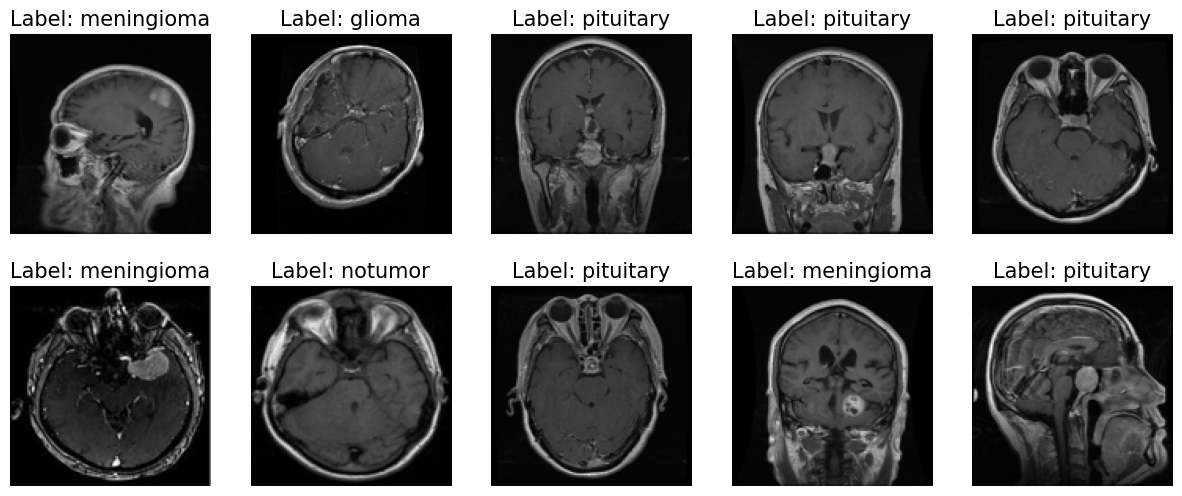

In [ ]:
import random
import matplotlib.pyplot as plt

#select random indices for 10 images
random_indices =random.sample(range(len(train_paths)), 10)
random_indices

#create a figure to display images in 2 rowa
fig , axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

#loop through the random indices and display images
for i, indx in enumerate(random_indices):
  img_path = train_paths[indx]
  img = Image.open(img_path)
  img = img.resize((128, 128))
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {train_labels[indx]}", fontsize=15)
  axes[i].axis('off')

plt.tight_layout
plt.show()


**Image Preprocessing (Helper Functions) **

In [ ]:
# Here we are creating some functions for image training

# Image Augmentation function
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image

# Load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = augment_image(img)
    images.append(img)
  return np.array(images)

# Encoder Labels(Convert label names to integer)
def encode_label(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

# Data generator for batching
def data_generator(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range (0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_label(batch_labels)
      yield batch_images, batch_labels




MODEL:

WE ARE USING VGG16 FOR TRANSFER LEARNING

In [ ]:


# Model Architecture
IMAGE_SIZE = 255
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top= False, weights='imagenet')

# Freeze all the layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False

# Set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build Model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))) #Input layer
model.add(base_model) #VGG16
model.add(Flatten()) #Flatten
model.add(Dropout(0.3)) #Dropout layer

model.add(Dense(128, activation='relu')) #Dense layer
model.add(Dropout(0.2)) # Dropout layer

model.add(Dense(len(os.listdir(train_dir)), activation='softmax')) #output layer

# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# train model
history = model.fit(data_generator(train_paths, train_labels, batch_size=batch_size, epochs=epochs), epochs = epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5274s 18s/step - loss: 0.6387 - sparse_categorical_accuracy: 0.7407
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5238s 18s/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9304
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5291s 19s/step - loss: 0.1075 - sparse_categorical_accuracy: 0.9633
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5265s 18s/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9700
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 5250s 18s/step - loss: 0.0585 - sparse_categorical_accuracy: 0.9780


Train and Values Plotting

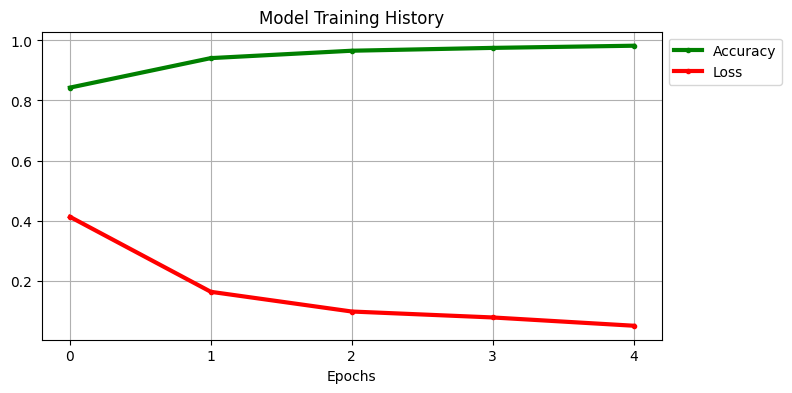

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=3)
plt.plot(history.history['loss'], '.r-', linewidth=3)
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Model Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

#make predictions on the test set
test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions,axis =1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 1020s 25s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       306
           1       0.99      0.91      0.95       300
           2       0.99      0.84      0.91       300
           3       1.00      1.00      1.00       405

    accuracy                           0.94      1311
   macro avg       0.95      0.93      0.94      1311
weighted avg       0.95      0.94      0.94      1311



Model Confusion Plot

Confusion Matrix:
[[304   0   2   0]
 [ 27 273   0   0]
 [ 47   2 251   0]
 [  2   0   0 403]]


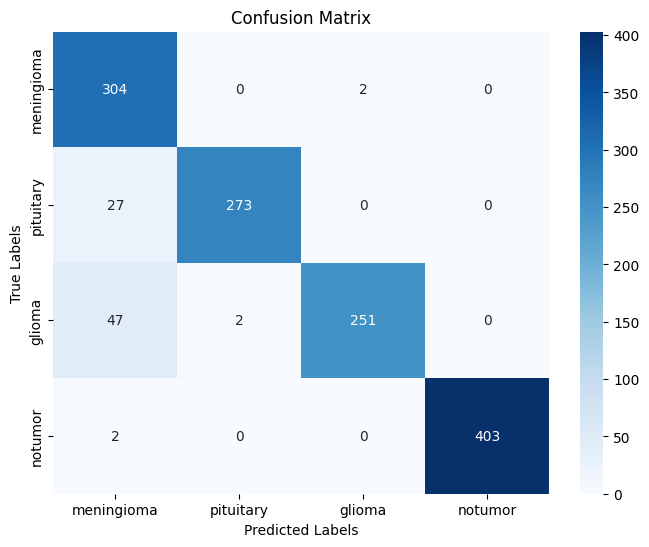

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

 Roc Curve Plot

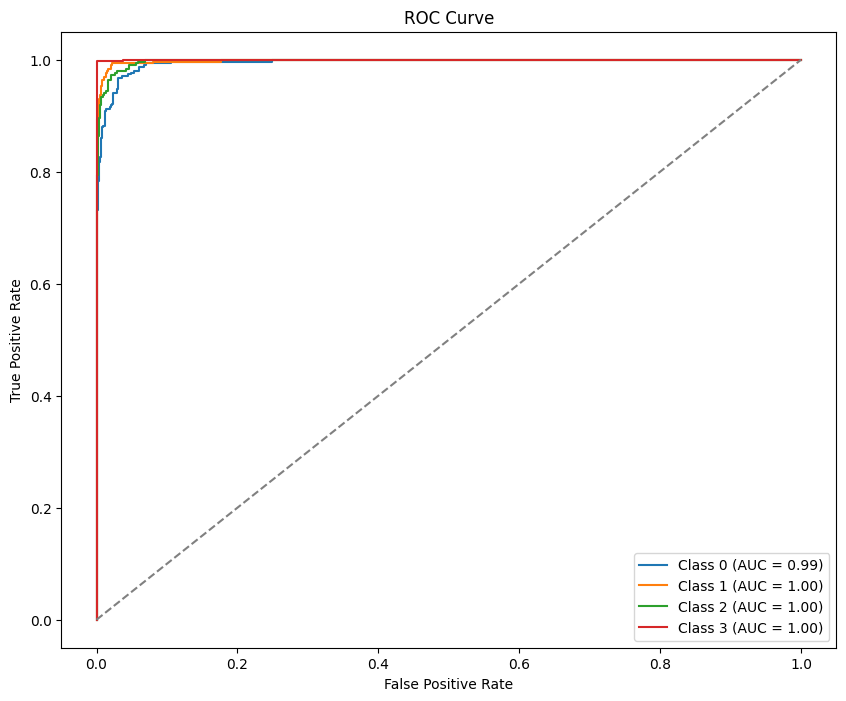

In [ ]:
#ROC Curve and AUC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions #The predicted probaboloties for the each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {},{},{}
for i in range(len(os.listdir(train_dir))):
  fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range (len(os.listdir(train_dir))):
  plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray') #
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()




Save and Load model

In [ ]:
from tensorflow.keras.models import load_model
#Save the entire model
model.save('model.h5')


MRI Tumor Detection System

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = ['Pituitary', 'Glioma', 'Notumor', 'Meningioma']
def detect_and_display(image_path, model):
  try:

    #load image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    #prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions, axis=1)[0]

    # determine the class
    if class_labels[predicted_class_index] == 'Notumor':
      result = "No Tumor Detected"
    else:
      result = f"Tumor: {class_labels[predicted_class_index]}"

    # Display
    plt.imshow(load_img(img_path))
    plt.title(f"{result}\nConfidence Score: {confidence_score * 100:.2f}%")
    plt.axis('off')
    plt.show()

  except Exception as e:
    print("Error processing the image:", str(e))
